<a href="https://colab.research.google.com/github/hardlyrichie/Poker-Classification/blob/master/Sarcasm_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Scarcasm Detection w/ Naive Bayes & N-Grams
Richard Gao, Sequence Modeling MiniProject

We are using a dataset from Kaggle that scraped reddit for sarcastic comments (reddit users demark sarcasm by using the \s ( sarcasm) tag) across multiple subreddits. With this dataset we classify between a sarcastic comment vs a normal comment.

Kaggle Dataset: https://www.kaggle.com/danofer/sarcasm/version/4#train-balanced-sarcasm.csv

In [0]:
import pandas as pd
import gdown
import numpy as np

Current matplotlib has broken heatmaps, need to downgrade.

https://datascience.stackexchange.com/questions/57245/seaborn-heatmap-not-displaying-correctly

In [0]:
!pip uninstall matplotlib -y
!pip install matplotlib==3.1.0

Uninstalling matplotlib-3.1.0:
  Successfully uninstalled matplotlib-3.1.0
  Using cached https://files.pythonhosted.org/packages/da/83/d989ee20c78117c737ab40e0318ea221f1aed4e3f5a40b4f93541b369b93/matplotlib-3.1.0-cp36-cp36m-manylinux1_x86_64.whl
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


### Download and Exploring data

In [0]:
gdown.download('https://drive.google.com/uc?authuser=0&id=1IKUQuNFOS604P6VyXyxRYvkQBlYh-B4z&export=download',  'train-balanced-sarcasm.csv', quiet=False)

Downloading...
From: https://drive.google.com/uc?authuser=0&id=1IKUQuNFOS604P6VyXyxRYvkQBlYh-B4z&export=download
To: /content/train-balanced-sarcasm.csv
255MB [00:02, 121MB/s] 


'train-balanced-sarcasm.csv'

In [0]:
df = pd.read_csv('train-balanced-sarcasm.csv')

In [0]:
df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010826 entries, 0 to 1010825
Data columns (total 10 columns):
label             1010826 non-null int64
comment           1010773 non-null object
author            1010826 non-null object
subreddit         1010826 non-null object
score             1010826 non-null int64
ups               1010826 non-null int64
downs             1010826 non-null int64
date              1010826 non-null object
created_utc       1010826 non-null object
parent_comment    1010826 non-null object
dtypes: int64(4), object(6)
memory usage: 77.1+ MB


The dataset clafficies 1 as sarcastic and 0 is normal.

Looking into the dataset, some comments are missing (1010826 labels vs 1010773 comments). We fix this by dropping the rows that have `na` comments.

In [0]:
df.dropna(subset=['comment'], inplace=True)

Let's look at the dataset

In [0]:
import matplotlib.pyplot as plt

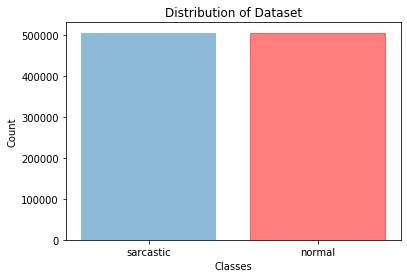

In [0]:
s = df.loc[df['label'] == 1, 'comment'].size
n = df.loc[df['label'] == 0, 'comment'].size
bar = plt.bar(['sarcastic', 'normal'], [s, n], align='center', alpha=0.5)
bar[1].set_color('r')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.title('Distribution of Dataset')
plt.show()

In [0]:
df['label'].mean()

0.4999816971763195

Let's look at sarcasm distributed between subreddits to see if a subreddit in this dataset is more sarcastic than another.

Most sarcastic subreddit with above 500 datapoints:

In [0]:
subreddits = df.groupby('subreddit')['label'].agg([np.size, np.mean])
subreddits[subreddits['size'] > 500].sort_values(by='mean', ascending=False).head(10)

,size,mean
subreddit,,
creepyPMs,5466,0.784303
progun,541,0.709797
rage,886,0.697517
MensRights,3355,0.680775
Bad_Cop_No_Donut,902,0.678492
ShitRedditSays,1284,0.661994
niceguys,910,0.653846
conspiratard,663,0.653092
worldnews,26376,0.642516


Least sarcastic subreddit with above 500 datapoints:

In [0]:
subreddits[subreddits['size'] > 500].sort_values(by='mean').head(10)

,size,mean
subreddit,,
Fireteams,510,0.035294
RoastMe,645,0.097674
me_irl,710,0.123944
Games,1341,0.227442
4chan,1074,0.245810
RocketLeagueExchange,508,0.257874
polandball,642,0.300623
buildapc,785,0.304459
CasualConversation,588,0.306122


## Training

### Building n-grams

We first clean up the text to extract just the words from the comments

In [0]:
# NLTK has a built-in module for extracting words from text.
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [0]:
def remove_punctuation(article):
  if not isinstance(article, str):
    article = str(article)
  # substitute in a regular apostrophe for '’' to word with word_tokenize
  article = article.replace('’', "'")
  tokens = nltk.tokenize.word_tokenize(article)
  words = list(filter(lambda w: any(x.isalpha() for x in w), tokens))
  return " ".join(words)

df['comment_no_punctuation'] = df['comment'].map(remove_punctuation)

In [0]:
df['comment_no_punctuation'].head()

0                                            NC and NH
1    You do know west teams play against west teams...
2    They were underdogs earlier today but since Gr...
3    This meme is n't funny none of the new york ni...
4                       I could use one of those tools
Name: comment_no_punctuation, dtype: object

In [0]:
import collections
from nltk.util import ngrams

A 2-gram for a certain comment.

In [0]:
s = df['comment_no_punctuation'].iloc[1]
tokens = [token for token in s.split(" ") if token != ""]
bigramWords = list(ngrams(tokens, 2))
bigramFreq = collections.Counter(bigramWords)

bigramFreq.most_common(10)

[(('west', 'teams'), 2),
 (('You', 'do'), 1),
 (('do', 'know'), 1),
 (('know', 'west'), 1),
 (('teams', 'play'), 1),
 (('play', 'against'), 1),
 (('against', 'west'), 1),
 (('teams', 'more'), 1),
 (('more', 'than'), 1),
 (('than', 'east'), 1)]

Split into test train

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
y = np.array(df['label'])

dfX_train, dfX_test, y_train, y_test = train_test_split(df['comment_no_punctuation'], y)
print("df_train.shape",dfX_train.shape)
print("y_train.shape",y_train.shape)
print("dfX_test.shape",dfX_test.shape)
print("y_test.shape",y_test.shape)

df_train.shape (758079,)
y_train.shape (758079,)
dfX_test.shape (252694,)
y_test.shape (252694,)


Build n-gram using CountVectorizer

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

In [0]:
ngramvectorizer = CountVectorizer(ngram_range=(2,2))
ngramvectorizer.fit(dfX_train) #learn a vocabulary dictionary of all tokens in the raw documents

X_train_ngram = ngramvectorizer.transform(dfX_train)
X_test_ngram = ngramvectorizer.transform(dfX_test)
print("X_train_ngram.shape", X_train_ngram.shape)
print("X_test_ngram.shape", X_test_ngram.shape)

X_train_ngram.shape (758079, 1801966)
X_test_ngram.shape (252694, 1801966)


Train and fit with Naive Bayes Model

In [0]:
# Actually run the model and print results
model = MultinomialNB(alpha=1)
model.fit(X_train_ngram, y_train)

y_pred_train = model.predict(X_train_ngram)
print("Training accuracy: ", np.mean(y_pred_train == y_train))
y_pred = model.predict(X_test_ngram)
print("Testing accuracy: ",np.mean(y_pred == y_test))

Training accuracy:  0.8945769504233727
Testing accuracy:  0.696676612820249


**Some Experimentation Results in Accuracy**

2-gram accuracy: 
* train: .89
* test: .70

3-gram accuracy: .65

5-gram accuracy: .53

2-5 gram accuracy: 
* train: .96
* test: .70

It looks like 2-grams are the most accurate in being features that represent sarcasm.

## Interpretation

In [0]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

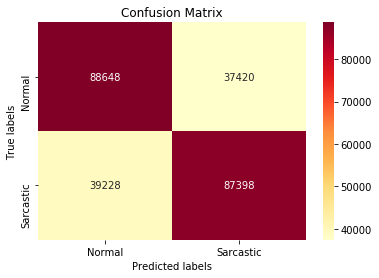

In [0]:
def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion matrix', cmap=plt.cm.YlOrRd):
  # Compute confusion matrix
  cm = confusion_matrix(y_true, y_pred)

  ax = plt.subplot()
  sns.heatmap(cm, annot=True, ax=ax, cmap=cmap, fmt='d')

  # labels, title and ticks
  ax.set_xlabel('Predicted labels')
  ax.set_ylabel('True labels')
  ax.set_title('Confusion Matrix') 
  ax.xaxis.set_ticklabels(classes) 
  ax.yaxis.set_ticklabels(classes)

# Plot confusion matrix
plt.figure()
classes = ['Normal', 'Sarcastic']
plot_confusion_matrix(y_test, y_pred, classes)

Let's find the most sarcastic and least sarcastic n-grams

In [0]:
# model.feature_log_prob_ gives us the log probability of each of the features
# conditioned on a particular class.
log_probs = model.feature_log_prob_
# model.classes_ tells us which class corresponds to a particular row in
# model.feature_log_prob_.
class_mapping = model.classes_

In [0]:
pos_index = np.where(class_mapping == 1)[0][0]
neg_index = np.where(class_mapping == 0)[0][0]

In [0]:
difference_in_log_probs_by_ngram = log_probs[pos_index,:] - log_probs[neg_index,:]
print(f"the n-gram that bumps up the log probability of a saracstic comment as much as possible is ({ngramvectorizer.get_feature_names()[np.argmax(difference_in_log_probs_by_ngram)]})")

the n-gram that bumps up the log probability of a saracstic comment as much as possible is (forgot your)


In [0]:
print(f"the n-gram that bumps up the log probability of a normal comment as much as possible is ({ngramvectorizer.get_feature_names()[np.argmin(difference_in_log_probs_by_ngram)]})")

the n-gram that bumps up the log probability of a normal comment as much as possible is (comcast comcast)


In [0]:
weighted_differences = np.multiply(X_test_ngram.mean(axis=0), difference_in_log_probs_by_ngram)

In [0]:
print(f"the n-gram that bumps up the log probability of a sarcastic comment as much as possible weighted by prevalence is ({ngramvectorizer.get_feature_names()[np.argmax(weighted_differences)]})")

the n-gram that bumps up the log probability of a sarcastic comment as much as possible weighted by prevalence is (forgot the)


In [0]:
print(f"the n-gram that bumps up the log probability of a normal comment as much as possible weighted by prevalence is ({ngramvectorizer.get_feature_names()[np.argmin(weighted_differences)]})")

the n-gram that bumps up the log probability of a normal comment as much as possible weighted by prevalence is (fuck fuck)


**Top most sarcastic n-grams**

In [0]:
least_ind = np.argsort(weighted_differences.getA()[0,:])
most_ind = least_ind[::-1]
ngrams = ngramvectorizer.get_feature_names()

In [0]:
n = 10
print(f"Top {n} most sarcastic n-grams: ")
for i in range(n):
  print(ngrams[most_ind[i]])

Top 10 most sarcastic n-grams: 
forgot the
you forgot
yeah because
yes because
but but
you dropped
dropped this
must be
yeah but
you re


**Least most sarcastic n-grams**

In [0]:
print(f"Top {n} least sarcastic n-grams: ")
for i in range(n):
  print(ngrams[least_ind[i]])

Top 10 least sarcastic n-grams: 
fuck fuck
trump donald
money money
of the
if you
in the
would be
you can
it was
one of
